# 8. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

### 패키지 로드

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from os.path import join


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 전처리

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

In [6]:
del train['id']
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

In [7]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

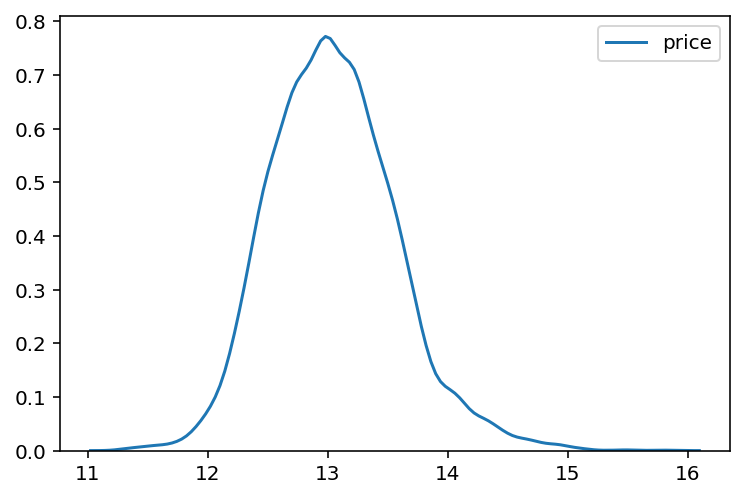

In [8]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
date             15035 non-null int64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(4), int64(15)
memory usage: 2.2 MB


### 모델 튜닝

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [11]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [14]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df
  
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125576.039323
LGBMRegressor,111920.367359
XGBRegressor,110318.637918


### 하이퍼 파라미터 튜닝

In [15]:
import random
from sklearn.model_selection import GridSearchCV

a = np.random.randint(1, 101, size = 20)


param_grid = {
    'n_estimators': a,
    'max_depth': a,
}

In [16]:
model = LGBMRegressor(random_state=random_state)

In [17]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 250 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 750 tasks      | elapsed:   22.5s
[Parallel(n_jobs=5)]: Done 1450 tasks      | elapsed:   42.7s
[Parallel(n_jobs=5)]: Done 2000 out of 2000 | elapsed:   58.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': array([71, 22, 44, 20, 74, 83, 87, 64, 57, 71, 71, 14, 96, 59,  3, 92, 85,
       85, 93, 10]),
                         'n_estimators': array([7

In [18]:
grid_model.cv_results_

{'mean_fit_time': array([0.17007103, 0.06852107, 0.10861416, 0.06342645, 0.15745406,
        0.16926389, 0.17025757, 0.14100122, 0.13336973, 0.15664258,
        0.1499999 , 0.05267119, 0.18432322, 0.12968326, 0.02811251,
        0.17976704, 0.17096772, 0.17679925, 0.18217974, 0.04125805,
        0.14900312, 0.06548467, 0.10666986, 0.06187139, 0.15221906,
        0.17352581, 0.18021641, 0.14524488, 0.12479382, 0.15437312,
        0.14904127, 0.05066347, 0.19101834, 0.12825942, 0.02953343,
        0.1812304 , 0.16854606, 0.16851501, 0.18718448, 0.04139271,
        0.14764047, 0.0685236 , 0.11099119, 0.0601799 , 0.15998597,
        0.17363415, 0.17738814, 0.14671092, 0.13406882, 0.14612055,
        0.15331779, 0.05082722, 0.19508204, 0.13825078, 0.02814875,
        0.19151292, 0.17154288, 0.17147574, 0.25341668, 0.04847302,
        0.1811698 , 0.08044834, 0.1260128 , 0.06684012, 0.20178075,
        0.20688848, 0.20277328, 0.17059121, 0.13597989, 0.15116773,
        0.15575781, 0.05245757,

In [19]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 71, 'n_estimators': 71},
 {'max_depth': 71, 'n_estimators': 22},
 {'max_depth': 71, 'n_estimators': 44},
 {'max_depth': 71, 'n_estimators': 20},
 {'max_depth': 71, 'n_estimators': 74},
 {'max_depth': 71, 'n_estimators': 83},
 {'max_depth': 71, 'n_estimators': 87},
 {'max_depth': 71, 'n_estimators': 64},
 {'max_depth': 71, 'n_estimators': 57},
 {'max_depth': 71, 'n_estimators': 71},
 {'max_depth': 71, 'n_estimators': 71},
 {'max_depth': 71, 'n_estimators': 14},
 {'max_depth': 71, 'n_estimators': 96},
 {'max_depth': 71, 'n_estimators': 59},
 {'max_depth': 71, 'n_estimators': 3},
 {'max_depth': 71, 'n_estimators': 92},
 {'max_depth': 71, 'n_estimators': 85},
 {'max_depth': 71, 'n_estimators': 85},
 {'max_depth': 71, 'n_estimators': 93},
 {'max_depth': 71, 'n_estimators': 10},
 {'max_depth': 22, 'n_estimators': 71},
 {'max_depth': 22, 'n_estimators': 22},
 {'max_depth': 22, 'n_estimators': 44},
 {'max_depth': 22, 'n_estimators': 20},
 {'max_depth': 22, 'n_estimators': 74},
 

In [20]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02780912, -0.04016394, -0.02999414, -0.04287089, -0.02767551,
       -0.0273717 , -0.02730268, -0.02811042, -0.02855743, -0.02780912,
       -0.02780912, -0.05762739, -0.02709335, -0.02841629, -0.17674501,
       -0.02718513, -0.02735392, -0.02735392, -0.02716136, -0.07823406,
       -0.02780912, -0.04016394, -0.02999414, -0.04287089, -0.02767551,
       -0.0273717 , -0.02730268, -0.02811042, -0.02855743, -0.02780912,
       -0.02780912, -0.05762739, -0.02709335, -0.02841629, -0.17674501,
       -0.02718513, -0.02735392, -0.02735392, -0.02716136, -0.07823406,
       -0.02780912, -0.04016394, -0.02999414, -0.04287089, -0.02767551,
       -0.0273717 , -0.02730268, -0.02811042, -0.02855743, -0.02780912,
       -0.02780912, -0.05762739, -0.02709335, -0.02841629, -0.17674501,
       -0.02718513, -0.02735392, -0.02735392, -0.02716136, -0.07823406,
       -0.02780912, -0.04016394, -0.02999414, -0.04287089, -0.02767551,
       -0.0273717 , -0.02730268, -0.02811042, -0.02855743, -0.02

In [21]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,71,71,-0.027809
1,71,22,-0.040164
2,71,44,-0.029994
3,71,20,-0.042871
4,71,74,-0.027676
...,...,...,...
395,10,92,-0.027179
396,10,85,-0.027347
397,10,85,-0.027347
398,10,93,-0.027166


In [22]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,71,71,-0.027809,0.166761
1,71,22,-0.040164,0.200409
2,71,44,-0.029994,0.173188
3,71,20,-0.042871,0.207053
4,71,74,-0.027676,0.166360
...,...,...,...,...
395,10,92,-0.027179,0.164861
396,10,85,-0.027347,0.165369
397,10,85,-0.027347,0.165369
398,10,93,-0.027166,0.164821


In [23]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,71,71,-0.027809,0.166761
1,71,22,-0.040164,0.200409
2,71,44,-0.029994,0.173188
3,71,20,-0.042871,0.207053
4,71,74,-0.027676,0.166360
...,...,...,...,...
395,10,92,-0.027179,0.164861
396,10,85,-0.027347,0.165369
397,10,85,-0.027347,0.165369
398,10,93,-0.027166,0.164821


In [24]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})

    return results

results

,max_depth,n_estimators,score,RMSLE
0,71,71,-0.027809,0.166761
1,71,22,-0.040164,0.200409
2,71,44,-0.029994,0.173188
3,71,20,-0.042871,0.207053
4,71,74,-0.027676,0.166360
...,...,...,...,...
395,10,92,-0.027179,0.164861
396,10,85,-0.027347,0.165369
397,10,85,-0.027347,0.165369
398,10,93,-0.027166,0.164821


In [25]:
param_grid = {'n_estimators': [95], 'max_depth': [16]}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished


,max_depth,n_estimators,score,RMSLE
0,16,95,-0.027068,0.164525


In [26]:
model = LGBMRegressor(max_depth=16, n_estimators=95, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.11911576, 13.07133131, 14.14228433, ..., 13.00527313,
       12.67713107, 12.97796669])

In [27]:
prediction = np.expm1(prediction)
prediction

array([ 498377.82748274,  475123.09800773, 1386486.7740951 , ...,
        444751.45844393,  320336.71393762,  432771.16336227])

In [28]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [29]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.983778e+05
1,15036,4.751231e+05
2,15037,1.386487e+06
3,15038,3.129848e+05
4,15039,3.303231e+05


In [30]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel0043/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


Public Score 기준  
113043.20860

앙상블 및 auto sklearn을 통한 예제 작업을 중이며, 이후 복습때에는 상기 2가지 기준을 마스터 하여 좋은 점수를 얻겠습니다.